Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

Paths to .csv files

In [2]:
data_dir = os.path.join("..", "data")
#fish_features = os.path.join(data_dir, "Combined_Brood_Bristol_Columbia_Fraser.csv")
fish_features = os.path.join(data_dir, "Brood_Return_First_Year_At_Sea_Tables", "Combined_Return_Bristol_Columbia_Fraser.csv")
pancea_features = os.path.join(data_dir, "GENERATED_pacea_series_annual.csv")
sst_df = os.path.join(data_dir, "sst_april_july_by_region.csv")
sss_df = os.path.join(data_dir, "sss_aprjun_mayaug_by_region.csv")
#sss_fraser_df = os.path.join(data_dir, "Fraser_River/Departure_Bay_PBS/Departure_Bay_PBS_-_Average_Monthly_Sea_Surface_Salinities_1914-2025.csv")
spawner_df = os.path.join(data_dir, "reforecastcompetitionsalmondatamobilization", "GENERATED_FullDataSet_LongForm.csv")
river_df = os.path.join(data_dir, "GENERATED_river_specific_features.csv")

Load feature sheets

In [3]:
fish_df = pd.read_csv(fish_features)
pancea_df = pd.read_csv(pancea_features)
sst_df = pd.read_csv(sst_df)
sss_df = pd.read_csv(sss_df)
#sss_fraser_df = pd.read_csv(sss_fraser_df, skiprows=1)
spawner_df = pd.read_csv(spawner_df, skiprows=3)
river_df = pd.read_csv(river_df)


Prepare fish_df

In [4]:
# Rename ReturnYear for clarity
fish_df = fish_df.rename(columns={'ReturnYear': 'Year'})

# Ensure years are sorted before shifting
fish_df = fish_df.sort_values(by=['System', 'River', 'Year'])

# Create prediction target: next year's Total_Returns
fish_df['Total_Returns_NextYear'] = fish_df.groupby(['System', 'River'])['Total_Returns'].shift(-1)

# Merge with climate/ocean features (PANCEA)
combined_df = fish_df.merge(pancea_df, how='left', on='Year')

Prepare river_df

In [5]:
# Build average over values if there is multiple river lines (different river sections) in a specific yeardf_
columns_to_average = [
    "mean_temp_JunAug", "mean_temp_MaySep", "max_temp_JunAug",
    "mean_discharge_MarMay", "max_discharge_AprSep"
]

river_df = (
    river_df.groupby(["Year", "River"], as_index=False)[columns_to_average].mean(numeric_only=True)
)

Merge with SST data

In [6]:
sst_suffix_map = {
    "Bristol Bay": "BristolBay",
    "Columbia River": "ColumbiaRiver",
    "Fraser River": "FraserRiver"
}

combined_df["sst_aprjul"] = pd.NA
combined_df["sst_anom"] = pd.NA

for i, row in combined_df.iterrows():
    system = row["System"]
    year = row["Year"]
    
    if system in sst_suffix_map:
        suffix = sst_suffix_map[system]
        sst_row = sst_df[sst_df["year"] == year]
        
        if not sst_row.empty:
            combined_df.at[i, "sst_aprjul"] = sst_row.iloc[0][f"sst_aprjul_{suffix}"]
            combined_df.at[i, "sst_anom"] = sst_row.iloc[0][f"sst_anom_{suffix}"]

Merge with SSS data

In [7]:
# Step 1: Melt sss_df to long format
sss_long = sss_df.melt(id_vars='Year', var_name='System_SSS', value_name='SSS')
# Extract system and season from the column name
sss_long[['System', 'Season']] = sss_long['System_SSS'].str.extract(r'(.+?)_sss_(\w+)$')

# Optional: Fix system names to match `combined_df`
system_mapping = {
    'BristolBay': 'Bristol Bay',
    'ColumbiaRiver': 'Columbia River',
    'FraserRiver': 'Fraser River'
}
sss_long['System'] = sss_long['System'].map(system_mapping)

# Pivot to have one row per Year-System with both aprjun and mayaug
sss_pivot = sss_long.pivot_table(index=['Year', 'System'], columns='Season', values='SSS').reset_index()
sss_pivot.columns.name = None  # Remove pandas category name
sss_pivot = sss_pivot.rename(columns={
    'aprjun': 'sss_aprjun',
    'mayaug': 'sss_mayaug'
})

# Step 2: Merge with combined_df
combined_df = pd.merge(combined_df, sss_pivot, on=['Year', 'System'], how='left')

Merge with spawner data

In [8]:
def get_spawner_values(row):
    year = row['Year']
    river = row['River']
    target_broodyears = [year - 2, year - 3, year - 4]

    # Filter for the target brood years
    matches = spawner_summary[
        (spawner_summary['River'] == river) &
        (spawner_summary['BroodYear'].isin(target_broodyears))
    ]

    # Initialize default values as NaN
    values = {
        'total_spawners_y_minus_2': float('nan'),
        'total_spawners_y_minus_3': float('nan'),
        'total_spawners_y_minus_4': float('nan'),
        'total_spawners_y_minus_2_to_4': float('nan')
    }

    # Assign individual values if available
    for offset in [2, 3, 4]:
        brood_year = year - offset
        match = matches[matches['BroodYear'] == brood_year]
        if not match.empty and pd.notna(match['Total_Spawners_BroodYear'].values[0]):
            values[f'total_spawners_y_minus_{offset}'] = match['Total_Spawners_BroodYear'].values[0]

    # If all three values are present, compute the sum
    if all(pd.notna(values[f'total_spawners_y_minus_{offset}']) for offset in [2, 3, 4]):
        values['total_spawners_y_minus_2_to_4'] = (
            values['total_spawners_y_minus_2'] +
            values['total_spawners_y_minus_3'] +
            values['total_spawners_y_minus_4']
        )

    return pd.Series(values)

spawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()

combined_df[
    ['total_spawners_y_minus_2', 'total_spawners_y_minus_3', 'total_spawners_y_minus_4', 'total_spawners_y_minus_2_to_4']
] = combined_df.apply(get_spawner_values, axis=1)

Merge with river-specific data

In [9]:
combined_df = pd.merge(combined_df, river_df, how='left', on=['Year', 'River'])

Add sea surface salinity data and Total_Spawners_BroodYear

In [10]:
'''
sss_fraser_df.replace(999.99, np.nan, inplace=True)
# Compute average salinity for April–June and May–August
sss_fraser_df['sss_aprjun'] = sss_fraser_df[['APR', 'MAY', 'JUN']].mean(axis=1)
sss_fraser_df['sss_mayaug'] = sss_fraser_df[['MAY', 'JUN', 'JUL', 'AUG']].mean(axis=1)

sss_fraser_df = sss_fraser_df[['YEAR', 'sss_aprjun', 'sss_mayaug']]
sss_fraser_df.rename(columns={'YEAR': 'Year'}, inplace=True)

fraser_mask = combined_df['System'] == 'Fraser River'
combined_df.loc[fraser_mask, ['sss_aprjun', 'sss_mayaug']] = combined_df[fraser_mask].merge(
    sss_fraser_df, how='left', on='Year')[['sss_aprjun', 'sss_mayaug']].values
'''
'''
spawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()
combined_df = combined_df.merge(
    spawner_summary,
    how='left',
    left_on=['Year', 'River'],
    right_on=['BroodYear', 'River']
)
'''

"\nspawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()\ncombined_df = combined_df.merge(\n    spawner_summary,\n    how='left',\n    left_on=['Year', 'River'],\n    right_on=['BroodYear', 'River']\n)\n"

Get the 2024 samples for final predictions and save them in a separate file

In [11]:
features_to_lag = [
    'Total_Returns', 'AgeClass_0.1', 'AgeClass_0.2', 'AgeClass_0.3', 'AgeClass_0.4', 'AgeClass_0.5',
    'AgeClass_1.1', 'AgeClass_1.2', 'AgeClass_1.3', 'AgeClass_1.4', 'AgeClass_1.5',
    'AgeClass_2.1', 'AgeClass_2.2', 'AgeClass_2.3', 'AgeClass_2.4',
    'AgeClass_3.1', 'AgeClass_3.2', 'AgeClass_3.3', 'AgeClass_3.4',
    'Total_Returns_NextYear', 'Pacea_ALPI_Anomaly', 'npi_mean_NovMar', 'oni_mean_DecFeb',
    'npgo_mean_DecFeb', 'ao_mean_DecMar', 'pdo_mean_DecMar', 'pdo_mean_MaySep'
]
# Create lag features on the full dataframe
for feat in features_to_lag:
    for lag in [1, 2, 3, 4, 5]:
        combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)

# Subset only year 2024 with all lag features
subset_2024 = combined_df[combined_df['Year'] == 2024].copy()

output_path = os.path.join(data_dir, "Samples_2024.csv")
subset_2024.to_csv(output_path, index=False)

C:\Users\julia\AppData\Local\Temp\ipykernel_30436\1753251739.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)
C:\Users\julia\AppData\Local\Temp\ipykernel_30436\1753251739.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)
C:\Users\julia\AppData\Local\Temp\ipykernel_30436\1753251739.py:12: PerformanceWarning: DataFrame is highly fragment

Drop rows where target is missing (i.e., last year of each group) and index column and Check for constant columns and drop duplicate rows

In [12]:
combined_df = combined_df.dropna(subset=['Total_Returns_NextYear'])
combined_df = combined_df.drop(columns=["Unnamed: 0"])

constant_cols = [col for col in combined_df.columns if combined_df[col].nunique() <= 1]
if constant_cols:
    print("Columns with only one unique value (consider dropping):")
    print(constant_cols)
else:
    print("No constant columns found.")

combined_df = combined_df.drop_duplicates()

No constant columns found.


Correlation matrix

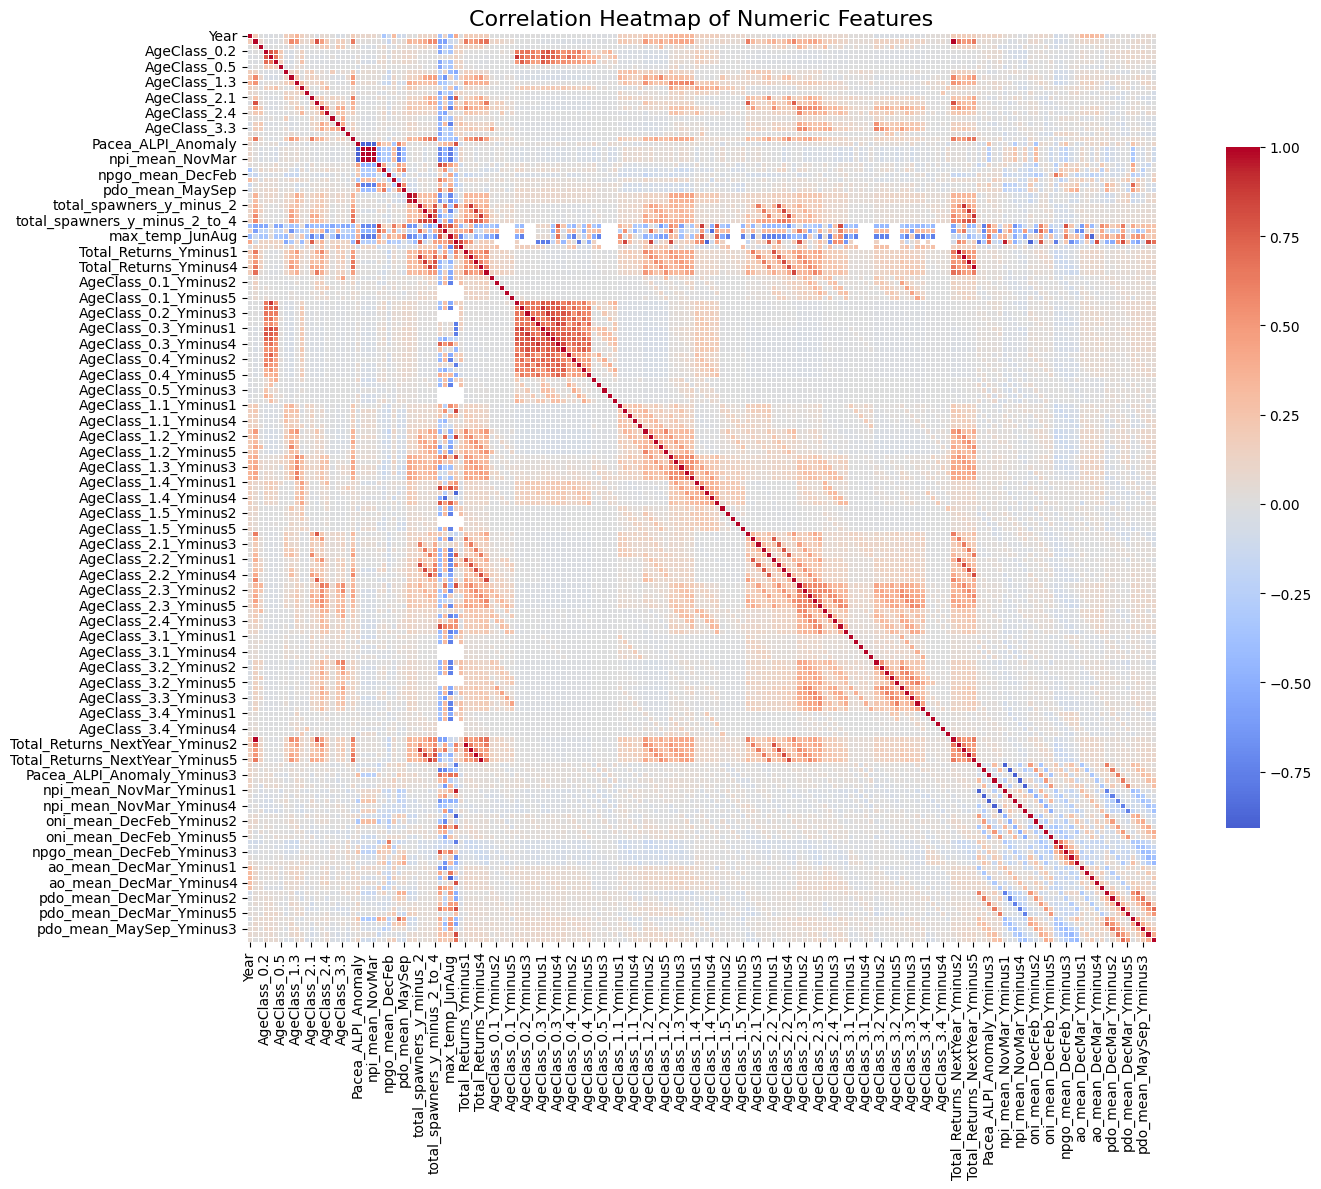

In [13]:
numeric_df = combined_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Generate the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()

Identify and print highly correlated feature pairs

In [14]:
def find_highly_correlated_features(corr_matrix, threshold=0.9):
    correlated_pairs = []
    to_remove = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                correlated_pairs.append((col1, col2, corr_value))
                to_remove.add(col2)  # Arbitrarily keep col1 and suggest removing col2
    return correlated_pairs, to_remove

high_corr_pairs, features_to_remove = find_highly_correlated_features(correlation_matrix, threshold=0.9)

# Print correlated pairs
print("\nHighly correlated feature pairs (|correlation| > 0.9):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} <--> {col2} | correlation: {corr_val:.2f}")

# Print features to consider removing
print("\nFeatures to consider removing due to high correlation:")
for feature in sorted(features_to_remove):
    print(f"- {feature}")


Highly correlated feature pairs (|correlation| > 0.9):
Pacea_NPI_Anomaly <--> Pacea_NPI_Value | correlation: 1.00
npi_mean_NovMar <--> Pacea_NPI_Value | correlation: 1.00
npi_mean_NovMar <--> Pacea_NPI_Anomaly | correlation: 1.00
sss_mayaug <--> sss_aprjun | correlation: 0.94
Total_Returns_NextYear_Yminus1 <--> Total_Returns | correlation: 1.00
Total_Returns_NextYear_Yminus2 <--> Total_Returns_Yminus1 | correlation: 1.00
Total_Returns_NextYear_Yminus3 <--> Total_Returns_Yminus2 | correlation: 1.00
Total_Returns_NextYear_Yminus4 <--> Total_Returns_Yminus3 | correlation: 1.00
Total_Returns_NextYear_Yminus5 <--> Total_Returns_Yminus4 | correlation: 1.00
npi_mean_NovMar_Yminus1 <--> mean_discharge_MarMay | correlation: 0.95
npi_mean_NovMar_Yminus2 <--> Pacea_ALPI_Anomaly_Yminus2 | correlation: -0.90
npi_mean_NovMar_Yminus3 <--> Pacea_ALPI_Anomaly_Yminus3 | correlation: -0.91
npi_mean_NovMar_Yminus4 <--> Pacea_ALPI_Anomaly_Yminus4 | correlation: -0.91
npi_mean_NovMar_Yminus5 <--> Pacea_ALP

Drop highly correlated or redundant columns

In [15]:
columns_to_drop = ['Pacea_NPI_Anomaly', 'Pacea_NPI_Value', 'sss_aprjun']
combined_df.drop(columns=columns_to_drop, inplace=True)

print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['Pacea_NPI_Anomaly', 'Pacea_NPI_Value', 'sss_aprjun']


Export to .csv

In [16]:
output_path = os.path.join(data_dir, "Combined_FeatureSet_For_Model.csv")
combined_df.to_csv(output_path, index=False)

num_samples = combined_df.shape[0]
num_features = combined_df.shape[1] - 1  # Exclude target variable if desired


print(f"Combined dataset saved to {output_path} with {num_samples} samples and {num_features} features.")

Combined dataset saved to ..\data\Combined_FeatureSet_For_Model.csv with 892 samples and 177 features.


Save separate files for each system

In [17]:
combined_df.columns

Index(['System', 'River', 'Year', 'Total_Returns', 'AgeClass_0.1',
       'AgeClass_0.2', 'AgeClass_0.3', 'AgeClass_0.4', 'AgeClass_0.5',
       'AgeClass_1.1',
       ...
       'pdo_mean_DecMar_Yminus1', 'pdo_mean_DecMar_Yminus2',
       'pdo_mean_DecMar_Yminus3', 'pdo_mean_DecMar_Yminus4',
       'pdo_mean_DecMar_Yminus5', 'pdo_mean_MaySep_Yminus1',
       'pdo_mean_MaySep_Yminus2', 'pdo_mean_MaySep_Yminus3',
       'pdo_mean_MaySep_Yminus4', 'pdo_mean_MaySep_Yminus5'],
      dtype='object', length=178)

In [18]:
for system in combined_df['System'].unique():
    system_df = combined_df[combined_df['System'] == system].copy()
    system_df = system_df.drop(columns=["System"])

    # Compute correlation matrix for numeric features only
    numeric_cols = system_df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols]
    corr_matrix = system_df[feature_cols].corr()

    # Identify highly correlated pairs
    high_corr_pairs = []
    for i in range(len(feature_cols)):
        for j in range(i + 1, len(feature_cols)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) >= 0.9:
                high_corr_pairs.append((feature_cols[i], feature_cols[j], round(corr, 3)))

    # Print results
    if high_corr_pairs:
        print(f"Highly correlated features in {system}:")
        for feat1, feat2, corr_val in high_corr_pairs:
            print(f"  {feat1} <--> {feat2}: correlation = {corr_val}")
    else:
        print(f"No highly correlated features (|r| ≥ 0.9) found in {system}.")

        
    # Drop specific correlated features for each system
    if system == "Columbia River":
        drop_cols = ['AgeClass_1.2', 'AgeClass_3.3']
        system_df = system_df.drop(columns=[col for col in drop_cols if col in system_df.columns])

    elif system == "Fraser River":
        drop_cols = ['AgeClass_1.2', 'Pacea_ALPI_Anomaly']
        system_df = system_df.drop(columns=[col for col in drop_cols if col in system_df.columns])
    
    # Save cleaned file
    system_path = os.path.join(data_dir, f"{system.replace(' ', '')}_FeatureSet_For_Model.csv")
    system_df.to_csv(system_path, index=False)

    sys_samples = system_df.shape[0]
    sys_features = system_df.shape[1] - 1

    print(f"{system} dataset saved to {system_path} with {sys_samples} samples and {sys_features} features.")

Highly correlated features in Bristol Bay:
  Total_Returns <--> Total_Returns_NextYear_Yminus1: correlation = 1.0
  AgeClass_2.1 <--> max_discharge_AprSep: correlation = 0.985
  AgeClass_2.3 <--> max_discharge_AprSep: correlation = 0.988
  AgeClass_3.2 <--> max_discharge_AprSep: correlation = 0.985
  total_spawners_y_minus_2_to_4 <--> max_discharge_AprSep: correlation = 0.938
  mean_discharge_MarMay <--> npi_mean_NovMar_Yminus1: correlation = 0.946
  max_discharge_AprSep <--> AgeClass_0.1_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_0.2_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_0.4_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_0.5_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_1.5_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_1.5_Yminus5: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_2.1_Yminus2: correlation = 0.985
  max_discharge_AprSep <--> AgeClass_2.1_Yminus4: correla